Notebook for STM double tip simulation

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
import os
import random
from scipy.ndimage import gaussian_filter, median_filter
from matplotlib import pyplot as plt
import tqdm

from pathlib import Path

In [12]:
def create_double_gaussian_kernel(size, peak1, peak2, sigma1, sigma2):
    kernel = np.zeros((size, size))
    
    # Create the first Gaussian peak
    kernel[peak1] = 1
    kernel = gaussian_filter(kernel, sigma=sigma1)
    
    # Create the second Gaussian peak
    kernel2 = np.zeros((size, size))
    kernel2[peak2] = 1
    kernel2 = gaussian_filter(kernel2, sigma=sigma2)
    
    # Combine the two Gaussians
    combined_kernel = kernel + kernel2
    
    return combined_kernel

# Define the kernel size and Gaussian parameters
kernel_size = 16
peak1 = (4, 4)  # Position of the first peak
peak2 = (11, 11)  # Position of the second peak
sigma1 = 1.0  # Standard deviation of the first Gaussian
sigma2 = 1.0  # Standard deviation of the second Gaussian

# Create the double Gaussian kernel
kernel = create_double_gaussian_kernel(kernel_size, peak1, peak2, sigma1, sigma2)

# Normalize the kernel
kernel /= np.sum(kernel)

print("Kernel shape:", kernel.shape)
print(kernel)

from scipy.ndimage import convolve

# Example array of shape (512, 512)
array = np.random.rand(512, 512)

# Convolve the array with the kernel
convolved_array = convolve(array, kernel)

print("Convolved array shape:", convolved_array.shape)


Kernel shape: (16, 16)
[[8.95531804e-09 2.96559404e-07 3.61283315e-06 1.61915949e-05
  2.66954268e-05 1.61915949e-05 3.61283315e-06 2.96559404e-07
  8.95531804e-09 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.96559404e-07 9.82069871e-06 1.19640603e-04 5.36191982e-04
  8.84031125e-04 5.36191982e-04 1.19640603e-04 9.82069871e-06
  2.96559404e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.61283315e-06 1.19640603e-04 1.45752092e-03 6.53215558e-03
  1.07697038e-02 6.53215558e-03 1.45752092e-03 1.19640603e-04
  3.61283315e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.61915949e-05 5.36191982e-04 6.53215558e-03 2.92750903e-02
  4.82664640e-02 2.92750903e-02 6.53215558e-03 5.36191982e-04
  1.61915949e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+

In [1114]:
# custom transforms

class Double_tip1(object):
  '''
  Add a double tip artefact to the image. The parameters of the double tip are chosen randomly so
  each image will have a different double tip artefact.
  '''

  def __init__(self):
    pass

  def sigmoid(self, x, a,b):
    '''
    A sigmoid function that takes in an array x and parameters a and b.
    This is used to rescale the pixel values in the "doubled" image (the brighter ones
    are often the ones that are doubled more clearly).
    args:
    x: array of pixel values
    a: parameter of the sigmoid function
    b: parameter of the sigmoid function
    returns:
    array of pixel values rescaled by the sigmoid function
    '''
    return 1 / (1 + np.exp(a-b*x))

  def __call__(self,array):
      # get random values for a and b
      # can adjust limits, these are preliminary
      b = np.random.uniform(8, 10)
      num_stds = np.random.uniform(3, 5)
      a = (torch.mean(array).item() + num_stds*torch.std(array).item()) * b
     # print(a,b,num_stds)
      # Apply the sigmoid function to each pixel value
      sigmoid_array = self.sigmoid(array,a,b)
      # Offset each pixel by a random value in x and y (between 5 and 10)
      # Generate random offsets for x and y
      offset_min = round(array.shape[1]*2/512)
      offset_max = round(array.shape[1]*5/512) 
      offset_x = torch.randint(offset_min, offset_max, (1,))[0]
      offset_y = torch.randint(offset_min, offset_max, (1,))[0]
      # make negative with 50% chance
      if random.random() < 0.5:
        offset_x = -offset_x
      if random.random() < 0.5:
        offset_y = -offset_y
     # print('offset in x and y: ', offset_x, offset_y)

      # Ensure offsets are within bounds
      _, rows, cols = array.shape

      # 80% of the time, apply median filter to sigmoided image,
      # other 20% apply gaussian
      if random.random() < 0.7:
        # random integer between 0 and 11
        median_size = np.random.randint(5, 7)
        #print('median size: ', median_size)
        # Apply median filter to the sigmoid image
        filtered_offset = median_filter(sigmoid_array, size=(1,median_size,median_size))
      else:
        # random num between 1 and 10
        gaussian_std = np.random.uniform(1.5, 2.5)
       # print('gaussian std: ', gaussian_std)
        filtered_offset = gaussian_filter(sigmoid_array, sigma=gaussian_std)

      # Create a copy of the base array
      result = torch.clone(array)

      # Add the add_array to the base_array with the offset
      # then crop it so it only includes the parts where the two arrays are overlaid
      if offset_x >= 0 and offset_y >= 0:
        # Positive offsets
        result[:,offset_x:, offset_y:] += filtered_offset[:,:rows-offset_x, :cols-offset_y]
        result = result[:,offset_x:, offset_y:]
        label = array[:,offset_x:, offset_y:]
      elif offset_x >= 0 and offset_y < 0:
        # Negative y-offset
        result[:,offset_x:, :offset_y] += filtered_offset[:,:rows-offset_x, -offset_y:]
        result = result[:,offset_x:, :offset_y]
        label = array[:,offset_x:, :offset_y]
      elif offset_x < 0 and offset_y >= 0:
        # Negative x-offset
        result[:,:offset_x, offset_y:] += filtered_offset[:,-offset_x:, :cols-offset_y]
        result = result[:,:offset_x, offset_y:]
        label = array[:,:offset_x, offset_y:]
      else:  # offset_x < 0 and offset_y < 0
        # Negative offsets for both x and y
        result[:,:offset_x, :offset_y] += filtered_offset[:,-offset_x:, -offset_y:]
        result = result[:,:offset_x, :offset_y]
        label = array[:,:offset_x, :offset_y]

      return torch.stack( (result, label), dim=0)[:,0,:,:]


class RandomScanLineArtefact(object):
    '''
    Randomly adds scan line artefacts to the image.
    Does a few different types of scan line artefacts:
    - Adds a constant to a single line in the image but for a longer length
    - Adds a constant to two lines in the image but for a longer length
    - Adds a sinusoidal wave to a single line in the image
    - Adds a sinusoidal wave to two lines in the image
    - Adds a constant to a single line in the image but for a shorter length
    '''
    def __init__(self, p):
        self.p = p

    def __call__(self, scan):
        r1 = random.random()
        r2 = random.random()
        scan_maxmin = (torch.clone(scan)-torch.min(scan))/(torch.max(scan)-torch.min(scan))

        if r1 < self.p:
          rng = np.random.default_rng() # random number generator
          res = scan.shape[1]
         # print(res)
          num_lines = 15 # number of lines to add artefact to
          lines = rng.integers(0,res, (num_lines,)) # which scan lines to augment
          columns = rng.integers(0,res-1, (num_lines,)) # the columns where the artefacts begin
          lengths = rng.integers(0, int(res*0.8), (num_lines,)) # the length of the artefacts
          add_ons = rng.random(size=(num_lines,))/2 # random number between 0 and 0.5 to add on to a scan line
          # add constant to single line
          for i in range(7):
            scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]] = scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]] + add_ons[i]
          # add constant to two lines one
          for i in range(7,9):
            scan_maxmin[:, lines[i]:lines[i]+2, columns[i]:columns[i]+lengths[i]] = scan_maxmin[:, lines[i]:lines[i]+2, columns[i]:columns[i]+lengths[i]] + add_ons[i]
          # add sinusoidal to single line
          for i in range(9,13):
            end_0 = round(res * 200/512)
            end_1 = round(res * 314/512)
            end = rng.integers(end_0,end_1)
            lengths[i] = scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]].shape[0] # correct length in case its too long
            cos = np.cos(np.linspace(0, end, num=lengths[i]) )
            #print(scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]].shape, scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]].shape, cos*add_ons[i].shape)
            scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]] = scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]] + cos*add_ons[i]
          # add sinusoidal to two lines
          for i in range(13,num_lines):
            end_0 = round(res * 200/512)
            end_1 = round(res * 314/512)
            end = rng.integers(end_0,end_1)
            lengths[i] = scan_maxmin[:, lines[i]:lines[i]+2, columns[i]:columns[i]+lengths[i]].shape[1] # correct length in case its too long
            cos = np.cos(np.linspace(0, end, num=lengths[i]) )
          #  print(scan_maxmin[:, lines[i]:lines[i]+2, columns[i]:columns[i]+lengths[i]].shape, scan_maxmin[:, lines[i]:lines[i]+2, columns[i]:columns[i]+lengths[i]].shape, torch.tensor(cos*add_ons[i]).unsqueeze(0).shape)
           
            scan_maxmin[:, lines[i]:lines[i]+2, columns[i]:columns[i]+lengths[i]] = scan_maxmin[:, lines[i]:lines[i]+2, columns[i]:columns[i]+lengths[i]] + torch.tensor(cos*add_ons[i]).unsqueeze(0)

        if r2 < self.p:
          # add some shorter scan line artefacts
          rng = np.random.default_rng() # random number generator
          res = scan.shape[1]
          lines = rng.integers(0,res, (10,)) # which scan lines to augment
          columns = rng.integers(0,res, (10,)) # the columns where the artefacts begin
          lengths = rng.integers(0, int(res*0.1) , (10,)) # the length of the artefacts
          add_ons = rng.random(size=(10,))/1.67 # random number between 0 and ~0.6 to add on to a scan line
          for i in range(10):
            scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]] =scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]] + add_ons[i]

        return scan_maxmin

# Custom transformation for random rotation
class RandomRotation_(object):
    '''
    Randomly rotates the image by an angle chosen from a list of angles.
    '''
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, img):
        img.transpose(0,1)
        angle = random.choice(self.angles)
        img_ =  F.rotate(img, angle)
        img_.transpose(0,1)
        return img_


class RandomCreep(object):
    '''
    Adds a creep to the top of the image with a probability of p.
    args:
    p: probability of adding a creep to the image. The image returned will not be square.
       Creep is added to the top or bottom of the image with equal probability. 
    res: if a resolution is given, the image will be returned with shape (2,res,res) (i.e. square) and there will be
         creep in it (with probability p). Otherwise, the returned image will not be square, and the resolution will vary
         depending on the creep, further cropping could then cut out the creep.
    '''
    def __init__(self, p, res=False):
        self.p = p
        self.res = res

    def __call__(self, scan):
        r = random.random()
        
        
        if r < self.p:
          r2 = random.random() # probability the creep is at bottom or top
          gt = scan[1,:,:]
          # generate 3 random ints
          num_lines = np.random.randint(40,50) # num lines the creep is visible in
          a1 = np.random.randint(0,50)
          a2 = np.random.randint(0,50) # factors in the creep polynomial
          sl = np.random.randint(0,scan.shape[-1]-200) # start line (sl), where the creep starts
          # we do scan.shape[-1]-200 to make sure the creep doesn't start too close to the edge (max shift due to creep is 180 pixels)
          scan_ = torch.clone(scan[0,:,:]).unsqueeze(0)
          #print('num_lines: ', num_lines, 'a1: ', a1, 'a2: ', a2, 'r2: ', r2)
          # add creep to top
          for i in range(0,num_lines):
            j = num_lines-i
            roll = (a1*i*i//250 + a2*i*i//100 +i*i//50) // 10
            scan_[0,2*j+sl:2*(j+1)+sl,:] = torch.roll(scan[0,2*j+sl:2*(j+1)+sl,:], -roll, dims=1)
          max_roll = (a1*(num_lines)**2//250 + a2*(num_lines)**2//100 + (num_lines)**2//50) // 10
          
          scan_ = scan_[0,sl:,max_roll:-max_roll]
          gt = gt[sl:,max_roll:-max_roll]
          output = torch.stack((scan_,gt))
  
          if self.res != False:
            output = output[:,0:self.res,:] # make sure creep is visible
            output = transforms.RandomCrop(self.res)(output)

          # flip with 50% probability
          if r2 < 0.5:
            output = output.flip(1)
          
          return output

        else:
          return scan


class MedianFilter(object):
    '''
    Applies a median filter to the image.
    '''
    def __init__(self, p):
        self.p = p
        

    def __call__(self, img):
          if self.p > random.random():
            # Convert the image to a NumPy array
            img_np = np.array(img)

            
            median_size = np.random.randint(2, 4)
          # print('median size: ', median_size)

            # Apply the median filter
            filtered_img_np = median_filter(img_np, size=median_size)

            # Convert the filtered image back to a tensor
            filtered_img = torch.tensor(filtered_img_np)

            return filtered_img
          return img


class Get_FFT(object):
    '''
    Applies a 2D FFT to the image.
    '''
    def __init__(self):
        pass

    def __call__(self, img):
        # make a 2d hanning window to avoid edge effects
        hanning = torch.hann_window(img.shape[1])
        hanning = hanning.unsqueeze(0) * hanning.unsqueeze(1)

        # Apply the 2D FFT
        fft_img = torch.fft.fft2(hanning*img[0,:,:])
        # shift the zero to centre
        fft_img = torch.fft.fftshift(fft_img)

        # Compute the magnitude of the FFT
        fft_img_real = torch.real(fft_img)
        fft_img_real = fft_img_real - torch.mean(fft_img_real)
        fft_img_imag = torch.imag(fft_img)
        fft_img_imag = fft_img_imag - torch.mean(fft_img_imag)
        # max/min normalise both of them
        fft_img_real = (fft_img_real - torch.min(fft_img_real))/(torch.max(fft_img_real) - torch.min(fft_img_real))
        fft_img_imag = (fft_img_imag - torch.min(fft_img_imag))/(torch.max(fft_img_imag) - torch.min(fft_img_imag))
       # print('fft_img_real shape: ', fft_img_real.shape)
       # print('fft_img_imag shape: ', fft_img_imag.shape)

        return torch.stack((fft_img_real, fft_img_imag), dim=0)

In [1123]:
class STM_double_tip_dataset(Dataset):
    def __init__(self, image_dir, length = 1500, empty = False):
        '''
        Args:
            image_dir (string): Directory with all the images. These are assumed as being numpy arrays.
                                Either with shape (res,res,2) (filled and empty), or just (res,res) (filled only).
            empty (bool): If True, the images are assumed as having filled and empty state images and both are wanted.
                          If False, we take only the filled state images.
            length (int): size of dataset
        '''
        self.length = length
        self.empty = empty
        self.image_dir = image_dir
        # check all files in image_dir have the same shape
        shapes = [np.load(image_dir+f,allow_pickle=True).shape for f in os.listdir(image_dir)]
       # print(shapes)
        if all(len(s)==3 for s in shapes):
            pass
        elif all(len(s)==2 for s in shapes):
            pass
       # else:
       #     file_list = [f for f in os.listdir(image_dir) if len(np.load(image_dir+f,allow_pickle=True).shape)==3]
        else:
            raise ValueError('All files in image_dir must have the same shape. Either (2, res, res) or (res, res). Currently, they are {}'.format(shapes))
        # load the data
        shape = len(shapes[0])
        if empty and shape == 3:
            self.image_files = [torch.tensor(np.load(image_dir+f,allow_pickle=True)) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
        elif empty and shape == 2:
            raise ValueError('empty=True only makes sense if the images have two channels.')
        elif not empty and shape == 2:
            self.image_files = [torch.tensor(np.load(image_dir+f,allow_pickle=True)) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
        elif not empty and shape == 3:
            self.image_files = [torch.tensor(np.load(image_dir+f,allow_pickle=True))[0,:,:] for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

        self.transforms_both = transforms.Compose([
            Double_tip1(),
            RandomRotation_([0, 90, 180, 270])
            ])

        self.creep_transform = RandomCreep(1, res=200)

        self.transforms_noise = transforms.Compose([
            MedianFilter(p=0.5),
            #RandomScanLineArtefact(0.7),
        ])

        '''
        Transforms order: random blur, random rotation, random brightness, creep, double tip, crop, resize
        '''

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        idx = idx % len(self.image_files)
        image = self.image_files[idx].unsqueeze(0)
        #print(image.shape)
        # max/min normalization
        image = (image-torch.min(image))/(torch.max(image)-torch.min(image))
        #print(image.shape)
        # transforms_both returns the original image (in first channel), and the double tip image in zeroth channel
        image = self.transforms_both(image)
        # apply creep
        #image = self.creep_transform(image[:,:])
        
        # We crop it after making the double tip, since the Double_tip1 and creep transforms
        # returns a non-square array (due to overlaying two images with a random offset in x and y)
        image = transforms.RandomCrop(200)(image)

        # The "label" is the original image, the "image" is the image with the double tip
        label = image[1,:,:]
        image = image[0,:,:]
       # print(image.shape)
        # Apply noise transforms, these are applied to the image only, not the "label"
        image = self.transforms_noise(image)
       # print(image.shape)

        # max/min normalization
        image = (image-torch.min(image))/(torch.max(image)-torch.min(image))
        label = (label-torch.min(label))/(torch.max(label)-torch.min(label))

        # get fft
      #  fft = Get_FFT()(image)
        #print('fft shape: ', fft.shape)
        # stack it with the image to get a 3 channel image
      #  image = torch.vstack((image, fft))

        return image.float(), label.float()

    def get_unaugmented(self, idx):
        idx = idx % len(self.image_files)
        image = self.image_files[idx].unsqueeze(0)
        #print(image.shape)
        # max/min normalization
        image = (image-torch.min(image))/(torch.max(image)-torch.min(image))
       
        # We crop it 
        image = transforms.RandomCrop(256)(image)
       
        # max/min normalization
        image = (image-torch.min(image))/(torch.max(image)-torch.min(image))
        
        return image.float()

In [1124]:
train_dataset = STM_double_tip_dataset(image_dir = 'filled_empty/train/')

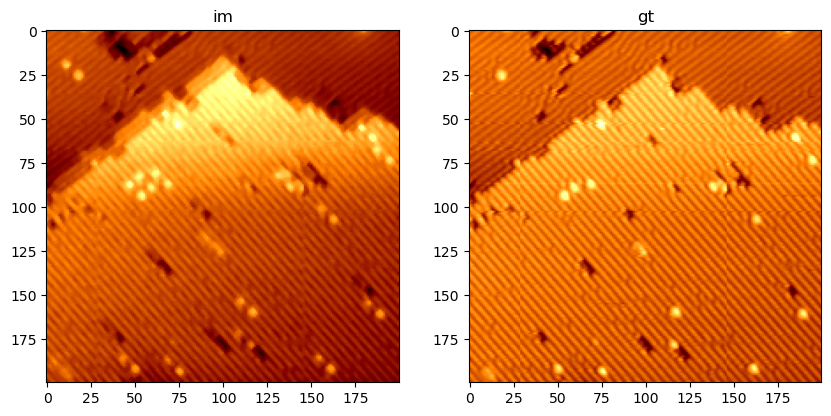

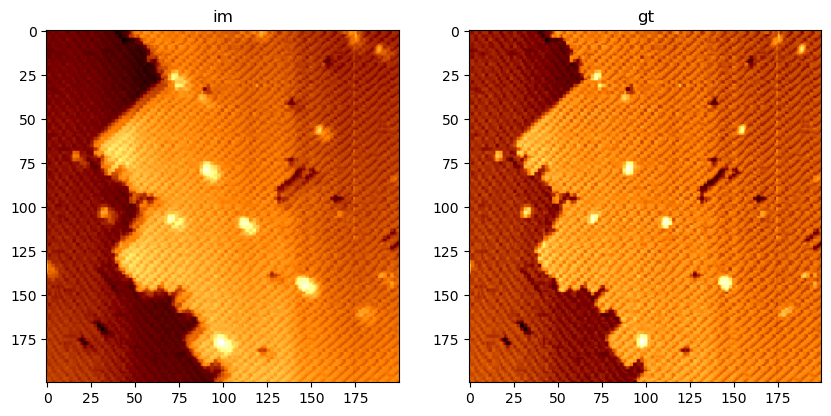

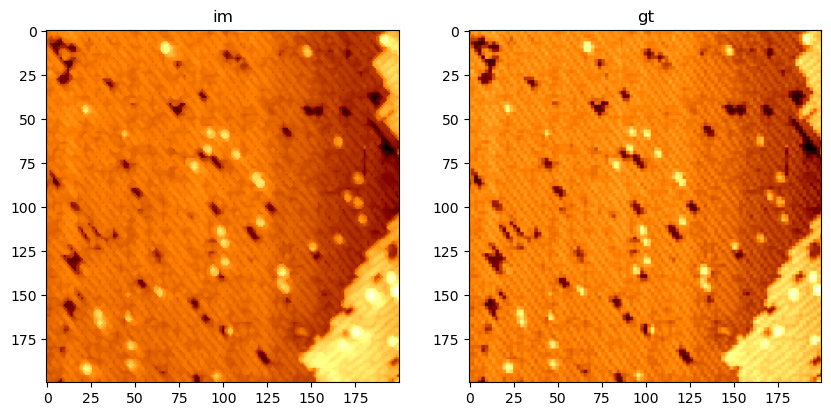

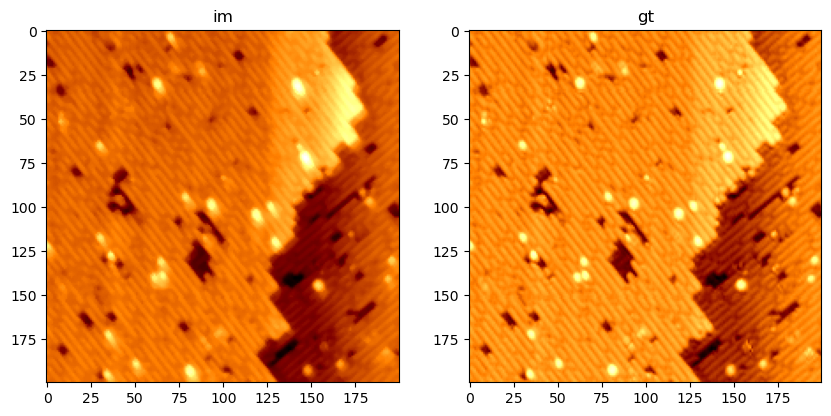

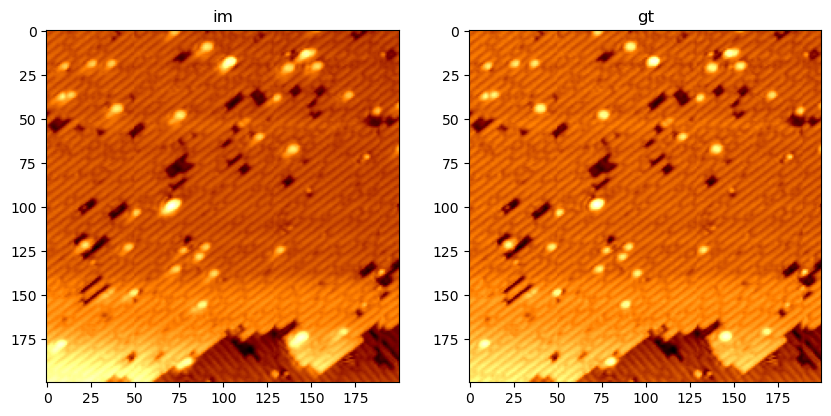

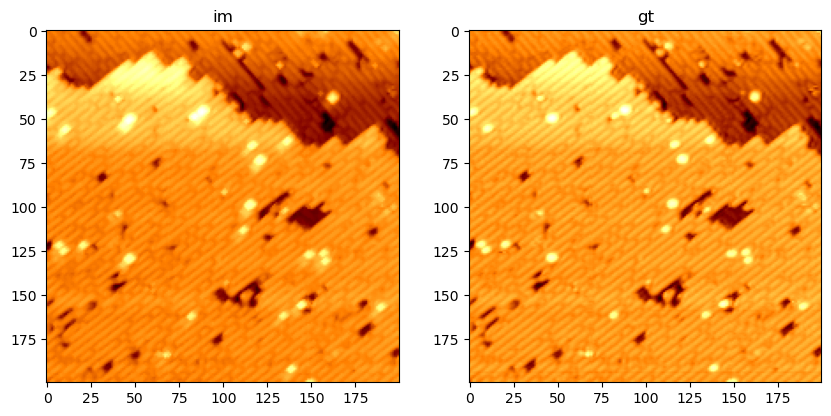

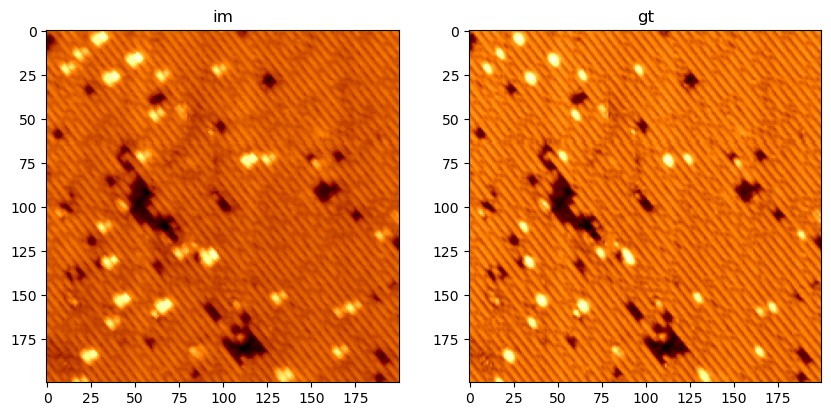

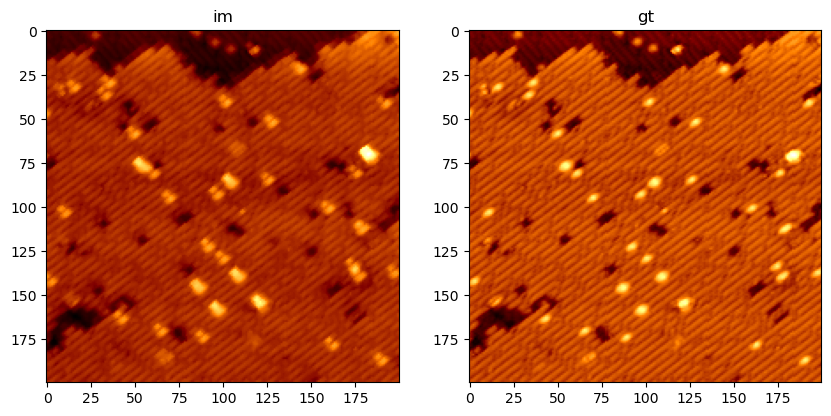

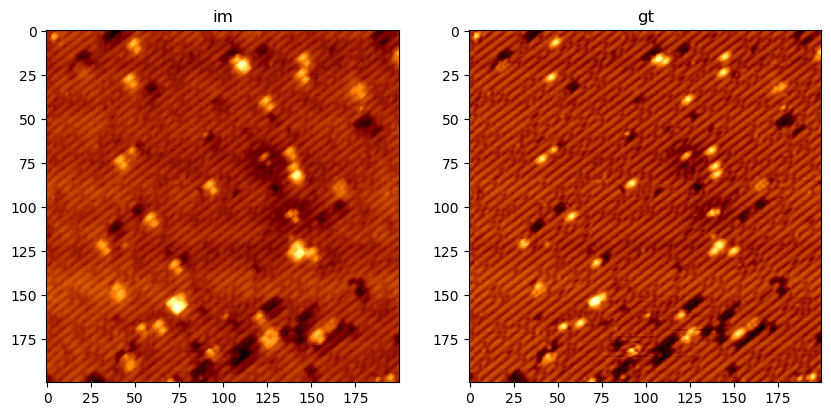

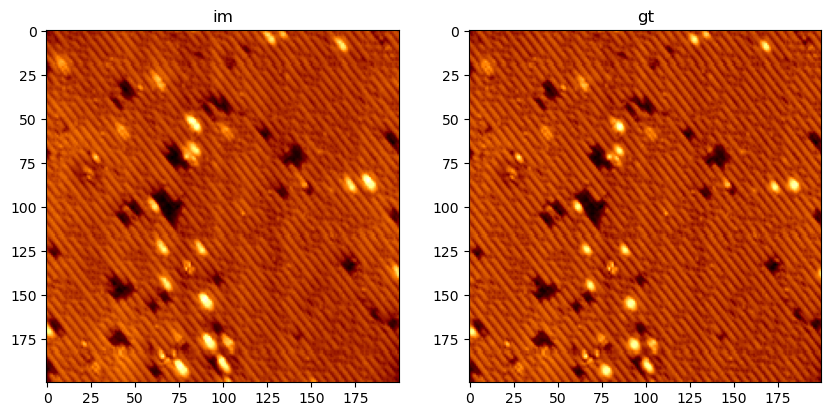

In [1125]:
for i in range(10):
    im, gt = train_dataset[i]
    #print('im.shape: ',im.shape)
    # plot im and gt 
    fig, ax = plt.subplots(1,2)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax[0].imshow(im, cmap='afmhot')
    ax[0].set_title('im')
    ax[1].imshow(gt, cmap='afmhot')
    ax[1].set_title('gt')
    plt.show()

In [ ]:
class UNetAutoencoder(nn.Module):
    def __init__(self):
        super(UNetAutoencoder, self).__init__()
        
        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc_relu1 = nn.ReLU(inplace=True)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_relu2 = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.bottleneck_conv = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bottleneck_relu = nn.ReLU(inplace=True)
        
        # Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec_relu1 = nn.ReLU(inplace=True)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec_relu2 = nn.ReLU(inplace=True)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        
    def forward(self, x):
        # Encoding path
        enc1 = self.enc_relu1(self.enc_conv1(x))
        enc2 = self.enc_relu2(self.enc_conv2(self.pool(enc1)))
        
        # Bottleneck
        bottleneck = self.bottleneck_relu(self.bottleneck_conv(self.pool(enc2)))
        
        # Decoding path
        up1 = self.upconv1(bottleneck)
        merge1 = torch.cat([up1, enc2], dim=1)
        dec1 = self.dec_relu1(self.dec_conv1(merge1))
        up2 = self.upconv2(dec1)
        merge2 = torch.cat([up2, enc1], dim=1)
        dec2 = self.dec_relu2(self.dec_conv2(merge2))
        
        # Final output
        out = self.final_conv(dec2)
        return out

In [864]:
# get directory
cwd = Path.cwd()
data_dir =  cwd / 'filled_empty'

# create instance of dataset
test_dataset = STM_double_tip_dataset(data_dir, empty=False)